# Configuration 



Dataset available on kaggle : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm import tqdm 

In [2]:
class CFG:
    
    epochs = 1                                         # No. of epochs of training the model 
    lr = 0.001                                         # Learning rate 
    batch_size = 16                                    # Batch Size For Dataset 
    
    model_name = 'tf_efficientnet_b4_ns'               # Model name 
    img_size = 224
    
    # Going to be use for loading dataset 
    DATA_DIR = "chest_xray_data"                       # Data Directory 
    TEST = 'test'                                      # Test folder name in data directory 
    TRAIN = 'train'                                    # Train folder name in data directory 
    VAL ='val'                                         # Valid folder name in data directory 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("On which device we are on : {}".format(device))

On which device we are on : cuda


# Image Transformation and Load Dataset 

In [3]:
from torchvision import transforms as T, datasets
from helper import show_image

In [4]:
train_transform = T.Compose([
    T.Resize((CFG.img_size, CFG.img_size)),
    T.RandomRotation(degrees= (-20, +20)),
    T.ToTensor(), #(h, w, c) -> (c, h, w)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((CFG.img_size, CFG.img_size)),
    T.ToTensor(), #(h, w, c) -> (c, h, w)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize((CFG.img_size, CFG.img_size)),
    T.ToTensor(), #(h, w, c) -> (c, h, w)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# load the dataset
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
val_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path, transform=train_transform)
valset = datasets.ImageFolder(val_path, transform=val_transform)
testset = datasets.ImageFolder(test_path, transform=test_transform)

In [6]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(valset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


In [7]:
trainset.classes

['NORMAL', 'PNEUMONIA']

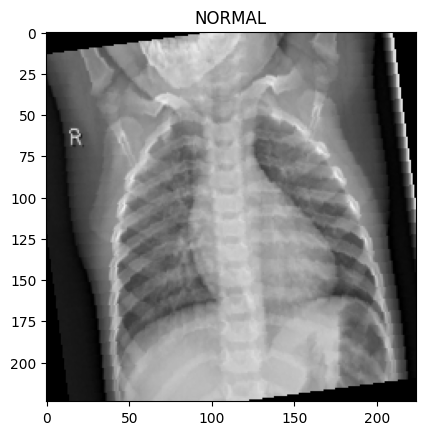

In [8]:
image, label = trainset[50]
class_names = ['NORMAL', 'PNEUMONIA']

show_image(image, class_names[label])

# Load Dataset into Batches 

In [9]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
from helper import show_grid

In [10]:
trainloader = DataLoader(trainset, batch_size=CFG.batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=CFG.batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=CFG.batch_size, shuffle=False)

In [11]:
print("No. of batches in trainloader : {}".format(len(trainloader)))
print("No. of Total examples : {}".format(len(trainloader.dataset)))

No. of batches in trainloader : 326
No. of Total examples : 5216


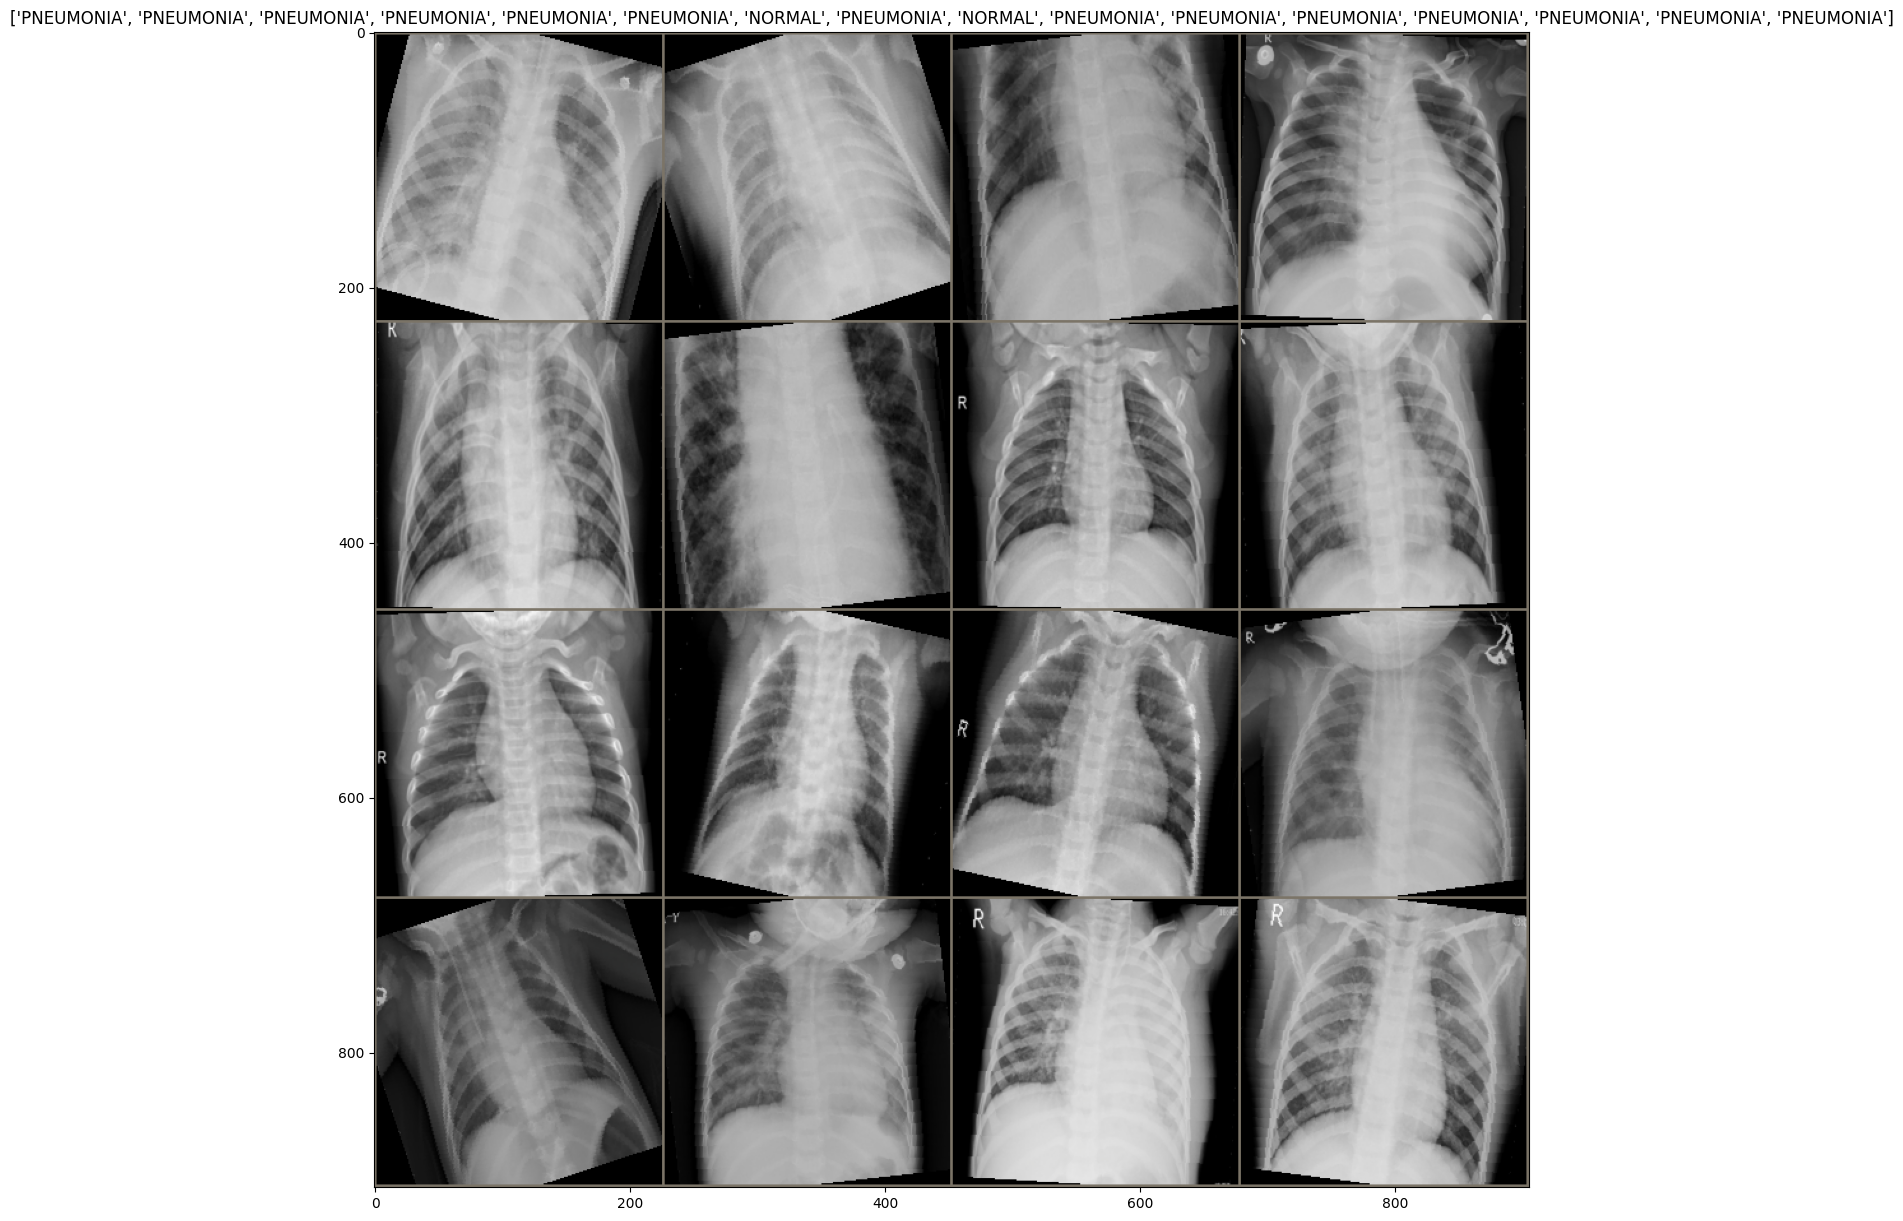

In [12]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

out = make_grid(images, nrow=4)

show_grid(out, title=[class_names[x] for x in labels])

# Fine Tuning EfficientNet Model 

In [13]:
from torch import nn 
import torch.nn.functional as F
import timm 

model = timm.create_model(CFG.model_name, pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625),
    nn.ReLU(),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2)
)

d:\anaconda\envs\venv\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


In [14]:
from torchsummary import summary 
model = model.to(device)
summary(model, input_size=(3, CFG.img_size, CFG.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
          Identity-9         [-1, 48, 112, 112]               0
           Conv2d-10             [-1, 12, 1, 1]             588
             SiLU-11             [-1, 12, 1, 1]               0
           Conv2d-12             [-1, 48, 1, 1]             624
          Sigmoid-13             [-1, 48, 1, 1]               0
    SqueezeExcite-14         [-1, 48, 1

# Build a Simple Trainer

In [15]:
from helper import accuracy

In [20]:
class PneumoniaTrainer():
    
    def __init__(self, criterion, optimizer, scheduler):
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    
    def train_batch_loop(self, model, trainloader):
        
        train_acc = 0.0
        train_loss = 0.0

        for images, labels in tqdm(trainloader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = self.criterion(logits, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
        
        return train_acc / len(trainloader), train_loss / len(trainloader)

    def valid_batch_loop(self, model, valloader):
        
        valid_acc = 0.0
        valid_loss = 0.0

        for images, labels in tqdm(valloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = self.criterion(logits, labels)

            valid_loss += loss.item()
            valid_acc += accuracy(logits, labels)
        
        return valid_acc / len(valloader), valid_loss / len(valloader)
            
        
    def fit(self, model, trainloader, valloader, epochs):
        model = model.to(device)
        valid_loss_min = np.Inf

        for epoch in range(epochs):
            model.train()
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, trainloader)
            
            model.eval()
            val_acc, val_loss = self.valid_batch_loop(model, valloader)
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, valloader)

            if avg_valid_loss <= valid_loss_min:
                print("Validation loss decreased from {:.4f} to {:.4f}. Saving model...".format(valid_loss_min, avg_valid_loss))
                torch.save(model.state_dict(), 'best_model.pt')
                valid_loss_min = avg_valid_loss
        
            print("Epoch : {} Train Loss : {:.4f} Train Acc : {:.4f}".format(epoch+1, avg_train_loss, avg_train_acc)) 
            print("--------------------------------------------------------------------------------------------------------------------------")
            print("\n")
            print("Epoch : {} Valid Loss : {:.4f} Valid Acc : {:.4f}".format(epoch+1, avg_valid_loss, avg_valid_acc))

        

# Training Model 

In [21]:
critertion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
scheduler = None

trainer = PneumoniaTrainer(critertion, optimizer, scheduler)
trainer.fit(model, trainloader, valloader, CFG.epochs)

Training:   0%|          | 0/326 [00:00<?, ?it/s]

Validation: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

Validation loss decreased from inf to 0.7591. Saving model...
Epoch : 1 Train Loss : 0.1924 Train Acc : 0.9197
--------------------------------------------------------------------------------------------------------------------------


Epoch : 1 Valid Loss : 0.7591 Valid Acc : 0.5000


# Plot Results 

In [27]:
from helper import view_classify

model.load_state_dict(torch.load('best_model.pth', map_location=device))

model.eval()
avg_test_acc, avg_test_loss = trainer.valid_batch_loop(model, testloader)

print("Test Loss : {}".format(avg_test_acc))
print("Test Acc : {}".format(avg_test_loss))

C:\Users\Mehdi\AppData\Local\Temp\ipykernel_9172\2724855460.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_locati

Test Loss : 0.8301281929016113
Test Acc : 0.3798763811445007


In [32]:
image.shape
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 224, 224])

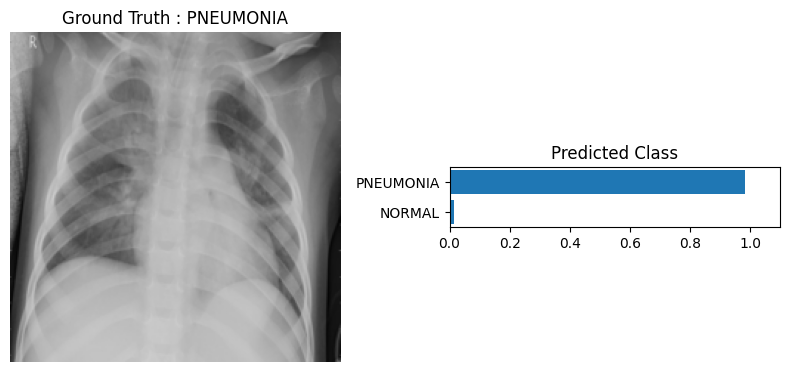

In [50]:
n = np.random.randint(0, len(testset))
image,label = testset[n]
image = image.to(device)
image = image.unsqueeze(0)
ps = model(image)
ps = F.softmax(ps,dim = 1)

image = image.cpu().squeeze()
view_classify(image,ps,label)